<a href="https://colab.research.google.com/github/ShriramGithub7/5_ModelForCIFAR10/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount model.py from drive and import required libraries

In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [9]:
!cp /content/drive/MyDrive/Colab\ Notebooks/model.py .

In [10]:
import model
import torch
import torchvision
from torchvision import datasets, transforms
import albumentations as A
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [11]:
net = model.Net()

# Apply Albumentation and transformation on dataset

In [5]:
mean=(0.4914, 0.4822, 0.4465)
std=(0.2023, 0.1994, 0.2010)

def albumentations_transform(image):
    image = np.array(image)
    augmented = A.Compose(
                [A.HorizontalFlip(),
                A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1,rotate_limit=45),
                A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1,min_height=16, min_width=16,
                           fill_value=np.mean(mean), mask_fill_value=None),
        ])(image=image)["image"]
    return transforms.ToTensor()(augmented)

transform = transforms.Compose([
    transforms.Lambda(albumentations_transform),
    transforms.Normalize(mean, std),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

batch_size = 4

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog','frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# View few images from the batch

  car   dog  deer plane


torch.Size([4, 3, 32, 32])

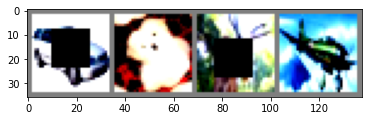

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

def show(img):
  img = img/2 + 0.5
  npimg= img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
images, labels= next(dataiter)


show(torchvision.utils.make_grid(images, normalize=False))

print(' '.join('%5s' % classes[labels[j]] for j in range (4)))

images.shape

# Use CUDA as a devide

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Create object of the model and print summary to know parameters

In [8]:
!pip install torchsummary
from torchsummary import summary

net = model.Net().to(device)
summary(net, input_size=(3, 32, 32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,640
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 15, 15]          18,496
      BatchNorm2d-10           [-1, 64, 15, 15]             128
             ReLU-11           [-1, 64, 15, 15]               0
          Dropout-12           [-1, 64, 15, 15]               0
    

# Model Training and Testing functions

In [10]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, trainloader, optimizer, epoch):
  #model.train()
  trainloader = trainloader
  correct = 0
  processed = 0
  running_loss = 0.0
  for batch_idx, data in enumerate(trainloader, 0):
    
    # get samples
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)


    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs).to(device)
    loss = criterion(outputs, labels)
    train_losses.append(loss.item())

    loss.backward()
    optimizer.step()

    pred = outputs.argmax(dim=1, keepdim=True)  
    correct += pred.eq(labels.view_as(pred)).sum().item()
    processed += len(data)

    running_loss += loss.item()

    if batch_idx % 6000 == 5999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, batch_idx + 1, running_loss / 6000))
            running_loss = 0.0


 
def test(model, device, testloader):
    test_loss = 0
    correct = 0
       
    with torch.no_grad():
        for data, labels in testloader:
            data, labels = data.to(device), labels.to(device)
            output = net(data)
            test_loss += criterion(output, labels).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()
         

    test_loss /= len(testloader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
          test_loss, correct, len(testloader.dataset),
          100. * correct / len(testloader.dataset)))
      
    test_acc.append(100. * correct / len(testloader.dataset))
  
  

# Setup loss and optimizer

In [12]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train the model and test accuracy after each epoch

In [ ]:
import torch.optim as optim

net =  model.Net().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

EPOCHS = 70

for epoch in range(EPOCHS):
    train(net, device, trainloader, optimizer, epoch)
    
    test(net, device, testloader)


[1,  6000] loss: 1.905
[1, 12000] loss: 1.686

Test set: Average loss: 0.4064, Accuracy: 4053/10000 (40.53%)

[2,  6000] loss: 1.556
[2, 12000] loss: 1.458

Test set: Average loss: 0.3572, Accuracy: 4757/10000 (47.57%)

[3,  6000] loss: 1.385
[3, 12000] loss: 1.338

Test set: Average loss: 0.3266, Accuracy: 5306/10000 (53.06%)

[4,  6000] loss: 1.287
[4, 12000] loss: 1.258

Test set: Average loss: 0.3082, Accuracy: 5564/10000 (55.64%)

[5,  6000] loss: 1.219
[5, 12000] loss: 1.201

Test set: Average loss: 0.3040, Accuracy: 5682/10000 (56.82%)

[6,  6000] loss: 1.172
[6, 12000] loss: 1.155

Test set: Average loss: 0.2912, Accuracy: 5846/10000 (58.46%)

[7,  6000] loss: 1.130
[7, 12000] loss: 1.127

Test set: Average loss: 0.2796, Accuracy: 6017/10000 (60.17%)

[8,  6000] loss: 1.092
[8, 12000] loss: 1.086

Test set: Average loss: 0.2729, Accuracy: 6180/10000 (61.80%)

[9,  6000] loss: 1.078
[9, 12000] loss: 1.063

Test set: Average loss: 0.2640, Accuracy: 6250/10000 (62.50%)

[10,  6000

NameError: ignored

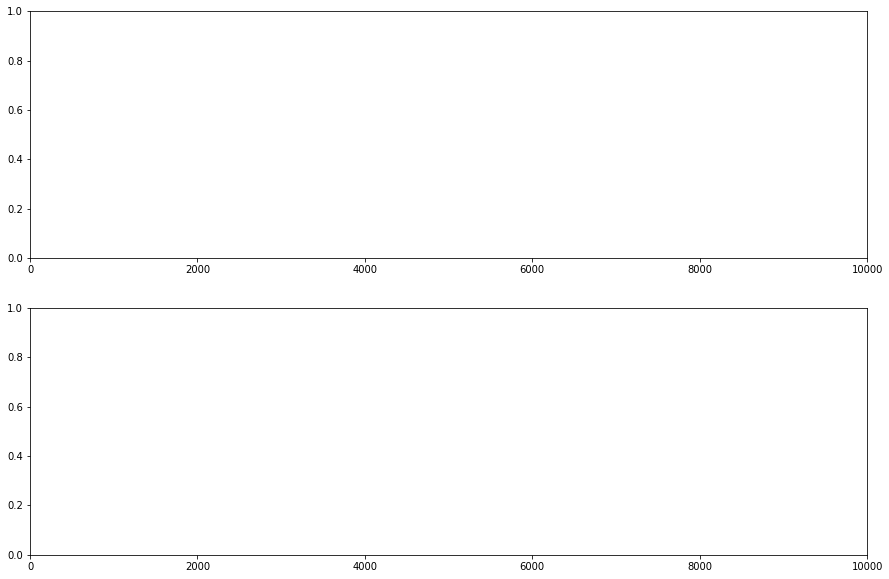

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,1,figsize=(15,10))
axs[0].set_xlim([0, 10000])
axs[1].set_xlim([0, 10000])

axs[0].plot(train_losses, color='red', label='Train Loss')
axs[0].plot(test_losses, color='blue', label='Test Loss')
axs[0].set_title("Test/Validation Loss")
axs[0].legend()

axs[1].plot(train_acc[100:], color='red', label='Train Accuracy')
axs[1].plot(test_acc, color='blue', label='Test Accuracy')

axs[1].set_title("Test/Validation Accuracy")
axs[1].legend()